# Preprocesado de las reseñas usando lematización

## Librerías importadas

In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt

## Carga y análisis de los datos iniciales

Al cargar los datos y ver su descripción, se dispone de 10 columnas. Únicamente se usan dos de ellas para el posterior proceso de NLP: Text y Score. El resto de columnas se eliminan más adelante. Cabe destacar también que no exiten filas con valores nulos en las columnas de interés, por lo que no se realizar ningún proceso de tratamiento de nulos.

In [2]:
df = pd.read_csv('Reviews.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


En la gráfica que se muestra a continuación, se puede apreciar una característica fundamental a tratar en esta fase de preprocesamiento: los datos están muy desbalanceados, acaparando las reseñas de puntuación 5 la gran mayoría, mientras que se dispone de muy pocas opiniones puntuadas con un 3.

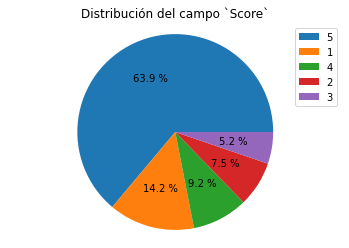

In [3]:
plt.title('Distribución del campo `Score`')
patches = plt.pie(df['Score'].value_counts(), autopct="%0.1f %%", radius=1000)
plt.legend(df['Score'].unique(), loc="best")
plt.axis("equal")
plt.show()

Como se mencionaba anteriormente, nos quedamos con las columnas Text y Score.

In [4]:
df.drop(df.columns.difference(['Text','Score']), axis=1, inplace=True)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   568454 non-null  int64 
 1   Text    568454 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


,Score
count,568454.000000
mean,4.183199
std,1.310436
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


A continuación, se trata el desbalance de datos. Para ello, se dispone de una función a contuación, que nos dará el mismo número de filas para cada Score disitnta (1 - 5).

In [5]:
def balanced_df(df):
    count  = df['Score'].value_counts()
    lower_range = min(count)
    n_features = len(count)
    g = df.groupby(['Score']).apply(lambda x: x.sample(lower_range))
    return g

El resultado del método definido anteriormente da como resultado un conjunto de datos con aproximadamente 1/5 del tamaño original. Por otra parte, se aprecia que la media de la columna Score es 3, por lo que se verifica que se dispone de datos balanceados.

In [6]:
df = balanced_df(df)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 148845 entries, (1, 112394) to (5, 248807)
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   148845 non-null  int64 
 1   Text    148845 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.1+ MB


,Score
count,148845.000000
mean,3.000000
std,1.414218
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


Reforzando la afirmación anterior, el siguiente gráfico muestra que, efectivamente, los datos están balanceados.

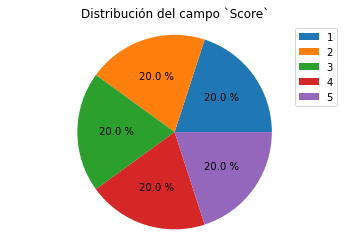

In [7]:
plt.title('Distribución del campo `Score`')
patches = plt.pie(df['Score'].value_counts(), autopct="%0.1f %%", radius=1000)
plt.legend(df['Score'].unique(), loc="best")
plt.axis("equal")
plt.show()

## Preprocesado del texto

A continuación, se realiza el tratamiento clásico de la columna Text.

In [8]:
text = df['Text']
text

Score        
1      112394    I bought this because the description said "No...
       345040    I looked forward to a delicious hot cocoa, but...
       93088     This was almost unedible.<br />I am a food sno...
       140739    there are plenty of other places online to get...
       82680     Before I bought the Essenza, I saw all of the ...
                                       ...                        
5      251312    Fructose is fructose. It's a simple sugar foun...
       238160    Cosmic Catnip is the best catnip ever !!!  I u...
       157389    I've been using this product for several month...
       250179    I HAVE ORDERED "TWO LEAVES AND A BUD" TEA FROM...
       248807    This is my favorite tea.  It's strong and spic...
Name: Text, Length: 148845, dtype: object

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Darkhorrow\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Se convierte todo el texto a minúsculas, ya que las mayúsuclas/minúsculas, en general, no alteran el significado de la frase.

In [10]:
text = text.apply(lambda x: x.lower())
text

Score        
1      112394    i bought this because the description said "no...
       345040    i looked forward to a delicious hot cocoa, but...
       93088     this was almost unedible.<br />i am a food sno...
       140739    there are plenty of other places online to get...
       82680     before i bought the essenza, i saw all of the ...
                                       ...                        
5      251312    fructose is fructose. it's a simple sugar foun...
       238160    cosmic catnip is the best catnip ever !!!  i u...
       157389    i've been using this product for several month...
       250179    i have ordered "two leaves and a bud" tea from...
       248807    this is my favorite tea.  it's strong and spic...
Name: Text, Length: 148845, dtype: object

Luego, se eliminan los símbolos de puntuación del texto. Estos tokens están disponibles en el módulo string.

In [11]:
text = text.apply(lambda x: ''.join([letter for letter in x if letter not in string.punctuation]))
text

Score        
1      112394    i bought this because the description said no ...
       345040    i looked forward to a delicious hot cocoa but ...
       93088     this was almost unediblebr i am a food snob bu...
       140739    there are plenty of other places online to get...
       82680     before i bought the essenza i saw all of the y...
                                       ...                        
5      251312    fructose is fructose its a simple sugar found ...
       238160    cosmic catnip is the best catnip ever   i use ...
       157389    ive been using this product for several months...
       250179    i have ordered two leaves and a bud tea from a...
       248807    this is my favorite tea  its strong and spicy ...
Name: Text, Length: 148845, dtype: object

A continuación, se realiza el proceso de tokenización (extracción de tokens), para lo que previeamente se descarga mediante nltk el/los fichero/s que conforma punkt.

In [12]:
text = text.apply(lambda x: nltk.word_tokenize(x))
text

Score        
1      112394    [i, bought, this, because, the, description, s...
       345040    [i, looked, forward, to, a, delicious, hot, co...
       93088     [this, was, almost, unediblebr, i, am, a, food...
       140739    [there, are, plenty, of, other, places, online...
       82680     [before, i, bought, the, essenza, i, saw, all,...
                                       ...                        
5      251312    [fructose, is, fructose, its, a, simple, sugar...
       238160    [cosmic, catnip, is, the, best, catnip, ever, ...
       157389    [ive, been, using, this, product, for, several...
       250179    [i, have, ordered, two, leaves, and, a, bud, t...
       248807    [this, is, my, favorite, tea, its, strong, and...
Name: Text, Length: 148845, dtype: object

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darkhorrow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

De manera similar a pasos anteriores, se eliminan las "stopwords" propia del idioma del texto, en este caso, inglés.

In [14]:
stop_words = nltk.corpus.stopwords.words('english')

In [15]:
text = text.apply(lambda x: [word for word in x if word not in stop_words])
text

Score        
1      112394    [bought, description, said, added, sugar, blat...
       345040    [looked, forward, delicious, hot, cocoa, disap...
       93088     [almost, unediblebr, food, snob, enjoy, good, ...
       140739    [plenty, places, online, get, spice, less, way...
       82680     [bought, essenza, saw, youtube, videos, reusab...
                                       ...                        
5      251312    [fructose, fructose, simple, sugar, found, pla...
       238160    [cosmic, catnip, best, catnip, ever, use, trai...
       157389    [ive, using, product, several, months, works, ...
       250179    [ordered, two, leaves, bud, tea, amazon, two, ...
       248807    [favorite, tea, strong, spicy, tastes, like, c...
Name: Text, Length: 148845, dtype: object

Con estos pasos realizados, disponemos de los tokens de cada reseña, que usaremos para la lematización.

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Darkhorrow\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [19]:
lematizer = nltk.stem.WordNetLemmatizer()
text = text.apply(lambda x: [lematizer.lemmatize(word) for word in x])
text

Score        
1      112394    [bought, description, said, added, sugar, blat...
       345040    [looked, forward, delicious, hot, cocoa, disap...
       93088     [almost, unediblebr, food, snob, enjoy, good, ...
       140739    [plenty, place, online, get, spice, le, way, d...
       82680     [bought, essenza, saw, youtube, video, reusabl...
                                       ...                        
5      251312    [fructose, fructose, simple, sugar, found, pla...
       238160    [cosmic, catnip, best, catnip, ever, use, trai...
       157389    [ive, using, product, several, month, work, we...
       250179    [ordered, two, leaf, bud, tea, amazon, two, oc...
       248807    [favorite, tea, strong, spicy, taste, like, ci...
Name: Text, Length: 148845, dtype: object

Finalmente, se deshace cada lista de tokens por reseña y se reconvierte a una frase, que en este punto ya se encuentra normalizada.

In [20]:
df['Text'] = text.apply(lambda x: ' '.join(x))
df['Text']

Score        
1      112394    bought description said added sugar blatant fa...
       345040    looked forward delicious hot cocoa disappointe...
       93088     almost unediblebr food snob enjoy good old kra...
       140739    plenty place online get spice le way descripti...
       82680     bought essenza saw youtube video reusable cap ...
                                       ...                        
5      251312    fructose fructose simple sugar found plant fru...
       238160    cosmic catnip best catnip ever use training ca...
       157389    ive using product several month work well sinc...
       250179    ordered two leaf bud tea amazon two occasion s...
       248807    favorite tea strong spicy taste like cinnamon ...
Name: Text, Length: 148845, dtype: object

## Guardado del preprocesamiento

Se guarda en formato CSV todo el preprocesamiento realizado en este notebook.

In [21]:
df.to_csv('ReviewsPreprocessingLematization.csv', index=False)